# US Census Commuter Tract Clustering

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, ClusterNode, fcluster
from scipy.spatial.distance import pdist, squareform
import gmaps
import gmaps.datasets

Data Imports

In [2]:
df_commute = pd.read_csv('data/commute_data.csv')

In [3]:
df_tracts = pd.read_csv('data/census_tracts_2010.csv')

In [4]:
df_tracts.rename(columns={'INTPTLONG                                                                                                                  ':'INTPTLONG'}, inplace=True)

EDA

In [5]:
df_commute.head()

,OFIPS,DFIPS,OSTFIPS,OCTFIPS,OTRFIPS,DSTFIPS,DCTFIPS,DTRFIPS,FLOW,MOE,LENKM,ESTDIVMOE
0,6073018700,6073018700,6,73,18700,6,73,18700,20950,2359,0.0,8.88
1,51710000902,51710000902,51,710,902,51,710,902,10155,2516,0.0,4.04
2,45079011501,45079011501,45,79,11501,45,79,11501,8735,875,0.0,9.98
3,13215010802,13215010802,13,215,10802,13,215,10802,7720,1144,0.0,6.75
4,6071010402,6071010402,6,71,10402,6,71,10402,7040,848,0.0,8.30


In [6]:
df_tracts.head()

,USPS,GEOID,POP10,HU10,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,AL,1001020100,1912,752,9809944,36312,3.788,0.014,32.477111,-86.490303
1,AL,1001020200,2170,822,3340505,5846,1.290,0.002,32.475758,-86.472468
2,AL,1001020300,3373,1326,5349274,9054,2.065,0.003,32.474024,-86.459703
3,AL,1001020400,4386,1823,6382705,16244,2.464,0.006,32.471078,-86.444681
4,AL,1001020500,10766,4308,11397725,48412,4.401,0.019,32.458916,-86.421817


In [7]:
df_tracts[df_tracts['USPS']=='CA'].sample(5)

,USPS,GEOID,POP10,HU10,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
7675,CA,6059063904,4658,1314,2481382,0,0.958,0.000,33.671451,-117.898911
9052,CA,6071006204,4495,1516,1131622,0,0.437,0.000,34.139209,-117.253567
6641,CA,6037576001,4969,3950,1769926,1325184,0.683,0.512,33.763116,-118.193863
4363,CA,6019005203,4519,1636,1304790,0,0.504,0.000,36.783209,-119.763401
5223,CA,6037199900,2683,813,443011,0,0.171,0.000,34.065079,-118.211576


Merged data sets, filter for CA, and fillna's

In [8]:
# Merge on OFIPS = GEOID (federal representation of census tract ID)
df_merged = df_commute.merge(df_tracts, how='inner', left_on='OFIPS', right_on='GEOID')
df_merged = df_merged.merge(df_tracts, how='inner', left_on='DFIPS', right_on='GEOID', suffixes = ('_O','_D'))

In [9]:
# Filter for CA tracts only
df_merged_CA = df_merged[df_merged['USPS_O']=='CA']

### Limit to Bay Area

In [11]:
minlat = 35.959793
maxlat = 38.419866
maxlong = -120.609292
minlong = -123.355416

df_merged_bay = df_merged_CA[(df_merged_CA['INTPTLONG_O']<maxlong) & (df_merged_CA['INTPTLONG_O']>minlong)]
df_merged_bay = df_merged_bay[(df_merged_bay['INTPTLONG_D']<maxlong) & (df_merged_bay['INTPTLONG_D']>minlong)]
df_merged_bay = df_merged_bay[(df_merged_bay['INTPTLAT_O']<maxlat) & (df_merged_bay['INTPTLAT_O']>minlat)]
df_merged_bay = df_merged_bay[(df_merged_bay['INTPTLAT_D']<maxlat) & (df_merged_bay['INTPTLAT_D']>minlat)]

df_merged_bay.sort_values('FLOW', ascending=False)

,OFIPS,DFIPS,OSTFIPS,OCTFIPS,OTRFIPS,DSTFIPS,DCTFIPS,DTRFIPS,FLOW,MOE,...,USPS_D,GEOID_D,POP10_D,HU10_D,ALAND_D,AWATER_D,ALAND_SQMI_D,AWATER_SQMI_D,INTPTLAT_D,INTPTLONG_D
183924,6053012600,6053012600,6,53,12600,6,53,12600,1935,439,...,CA,6053012600,2254,83,1623726,102018,0.627,0.039,36.604516,-121.911505
168209,6075061500,6075061500,6,75,61500,6,75,61500,1775,318,...,CA,6075061500,11502,8255,1669699,439739,0.645,0.170,37.787726,-122.392389
250345,6081613700,6081613700,6,81,613700,6,81,613700,1330,327,...,CA,6081613700,8755,3484,110079587,6797967,42.502,2.625,37.451344,-122.367218
251802,6085513000,6085513000,6,85,513000,6,85,513000,1265,273,...,CA,6085513000,8215,2982,2753101,0,1.063,0.000,37.428838,-122.161792
1095662,6047000402,6047000402,6,47,402,6,47,402,1225,291,...,CA,6047000402,8071,2874,118003134,1854113,45.561,0.716,37.399871,-120.895361
235388,6075061500,6075011700,6,75,61500,6,75,11700,1065,270,...,CA,6075011700,1783,1416,556044,0,0.215,0.000,37.790467,-122.403486
1099277,6099003202,6099003202,6,99,3202,6,99,3202,1065,270,...,CA,6099003202,16007,4984,15550750,0,6.004,0.000,37.464793,-121.144969
1647573,6053011000,6053011000,6,53,11000,6,53,11000,1050,275,...,CA,6053011000,5933,3176,489637049,1555086,189.050,0.600,36.391364,-121.680622
1117107,6095253500,6095253500,6,95,253500,6,95,253500,1025,238,...,CA,6095253500,8423,4283,576996041,28782850,222.779,11.113,38.205026,-121.771600
1096776,6099003500,6099003500,6,99,3500,6,99,3500,995,229,...,CA,6099003500,10720,3527,17064269,53050,6.589,0.020,37.313356,-121.029623


### Alex messing around with plots

(-123, -121.5)

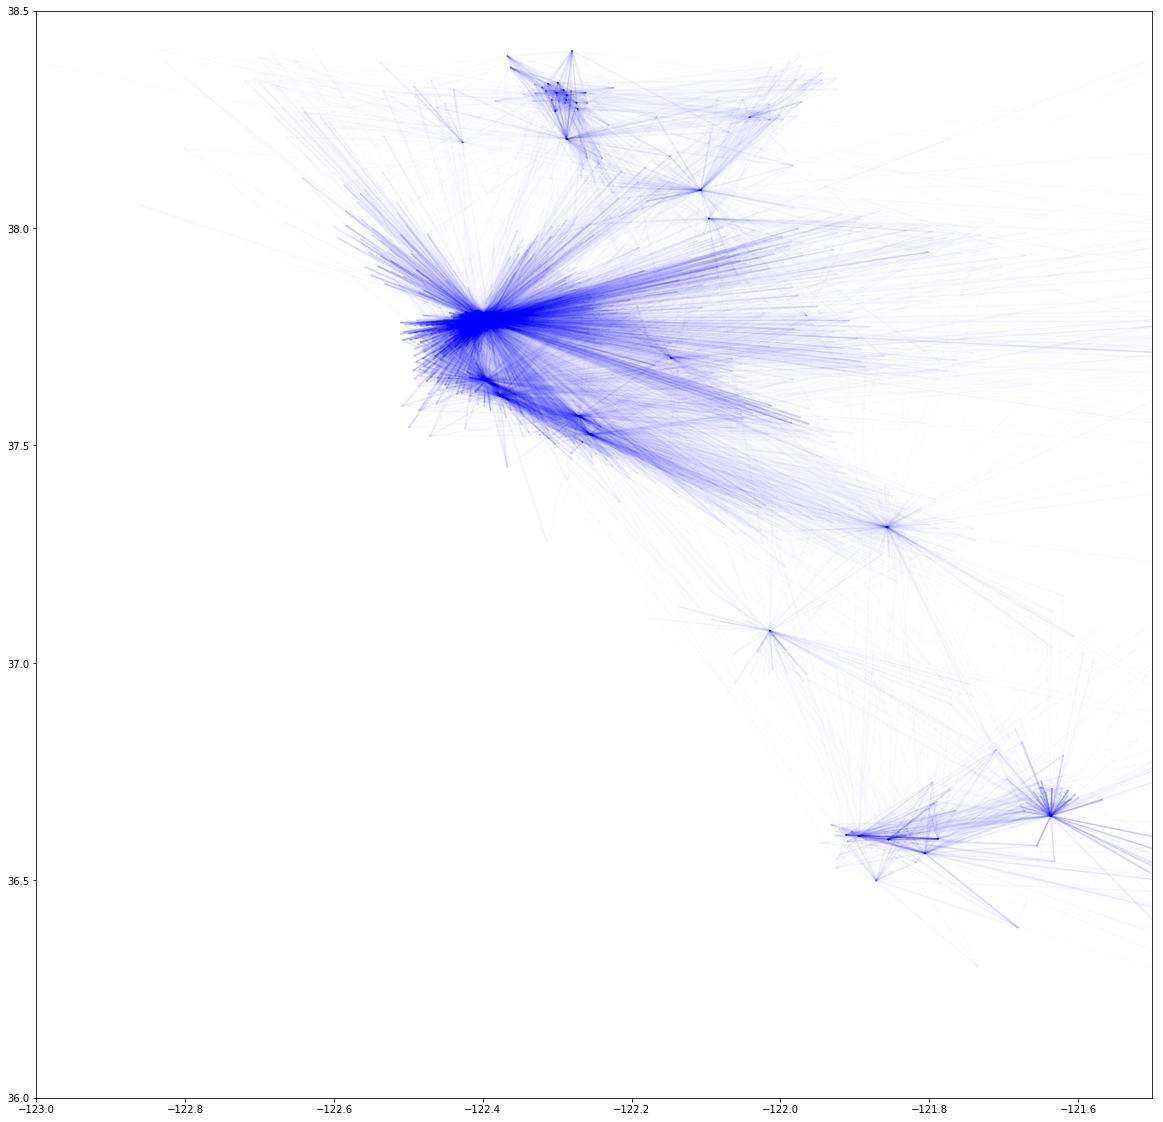

In [12]:
plt.figure(figsize=(20,20))
flow_max = df_merged_bay['FLOW'].max()
n = 10000
for i, row in df_merged_bay.head(n).iterrows():
    plt.plot((row['INTPTLONG_O'],row['INTPTLONG_D']),(row['INTPTLAT_O'],row['INTPTLAT_D']), alpha=(row['FLOW']/flow_max), color='b')

plt.ylim(36,38.5)
plt.xlim(-123,-121.5)

### Hierarchical Clustering

In [200]:
df_pivot = df_merged_bay.pivot(index='OFIPS', columns='DFIPS', values='FLOW')
df_pivot.shape

(7987, 10598)

In [201]:
df_pivot = df_pivot.fillna(0)
df_pivot.shape

(7987, 10598)

In [202]:
set_D = set(df_merged_bay['DFIPS'].unique())
set_O = set(df_merged_bay['OFIPS'].unique())
drop_ids = list((set_D | set_O) - (set_D & set_O))

In [173]:
df_pivot = df_pivot.drop(index = drop_ids, columns=drop_ids, errors='ignore')

In [174]:
df_pivot.values.max()

1935.0

In [175]:
#Option 1: absolute number of commuters
#df_pivot = df_pivot.values.max()/(1+df_pivot)

In [176]:
#Option 2: percentages of all origin commuters
df_max = df_pivot.sum(axis=1)
df_pivot = df_pivot.divide(df_max, axis=0)
df_pivot = 1/(1+df_pivot)

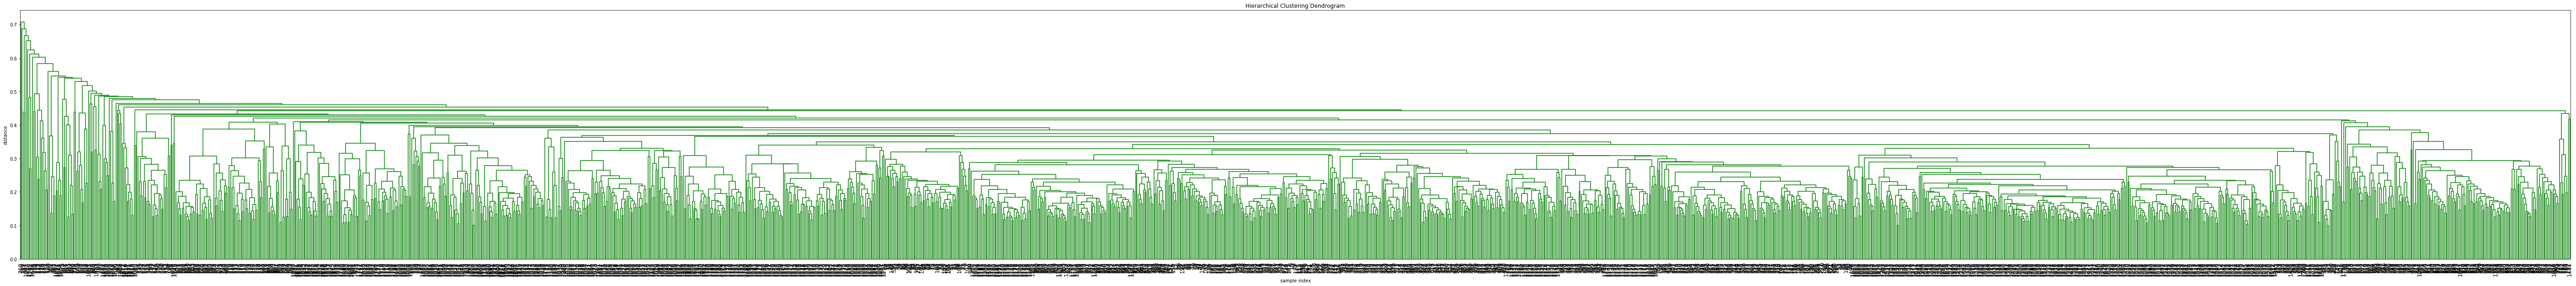

In [177]:
linkage_method = 'complete'
Z = linkage(df_pivot, linkage_method)
plt.figure(figsize=(100, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    color_threshold = 25000
)
plt.show()

In [192]:
k = 500
df_results = pd.DataFrame(index = df_pivot.columns, data=fcluster(Z,k,criterion='maxclust'))

In [193]:
df_results = df_results.rename(columns={0: 'cluster_id'})

In [194]:
df_results = df_results.merge(df_tracts, left_index=True, right_on='GEOID')

In [195]:
cluster_order = list(df_results.groupby('cluster_id').count().sort_values('GEOID', ascending=False).index)

In [196]:
from matplotlib import cm
colors = []
for i, val in enumerate(cluster_order):
    (r, g, b, a) = cm.Paired(i%10)
    colors.append((val,(int(255*r), int(255*g), int(255*b), a)))
colors = pd.DataFrame(colors, columns=['cluster_id','color'])

In [197]:
df_results = df_results.merge(colors, on='cluster_id')

(-123, -120.5)

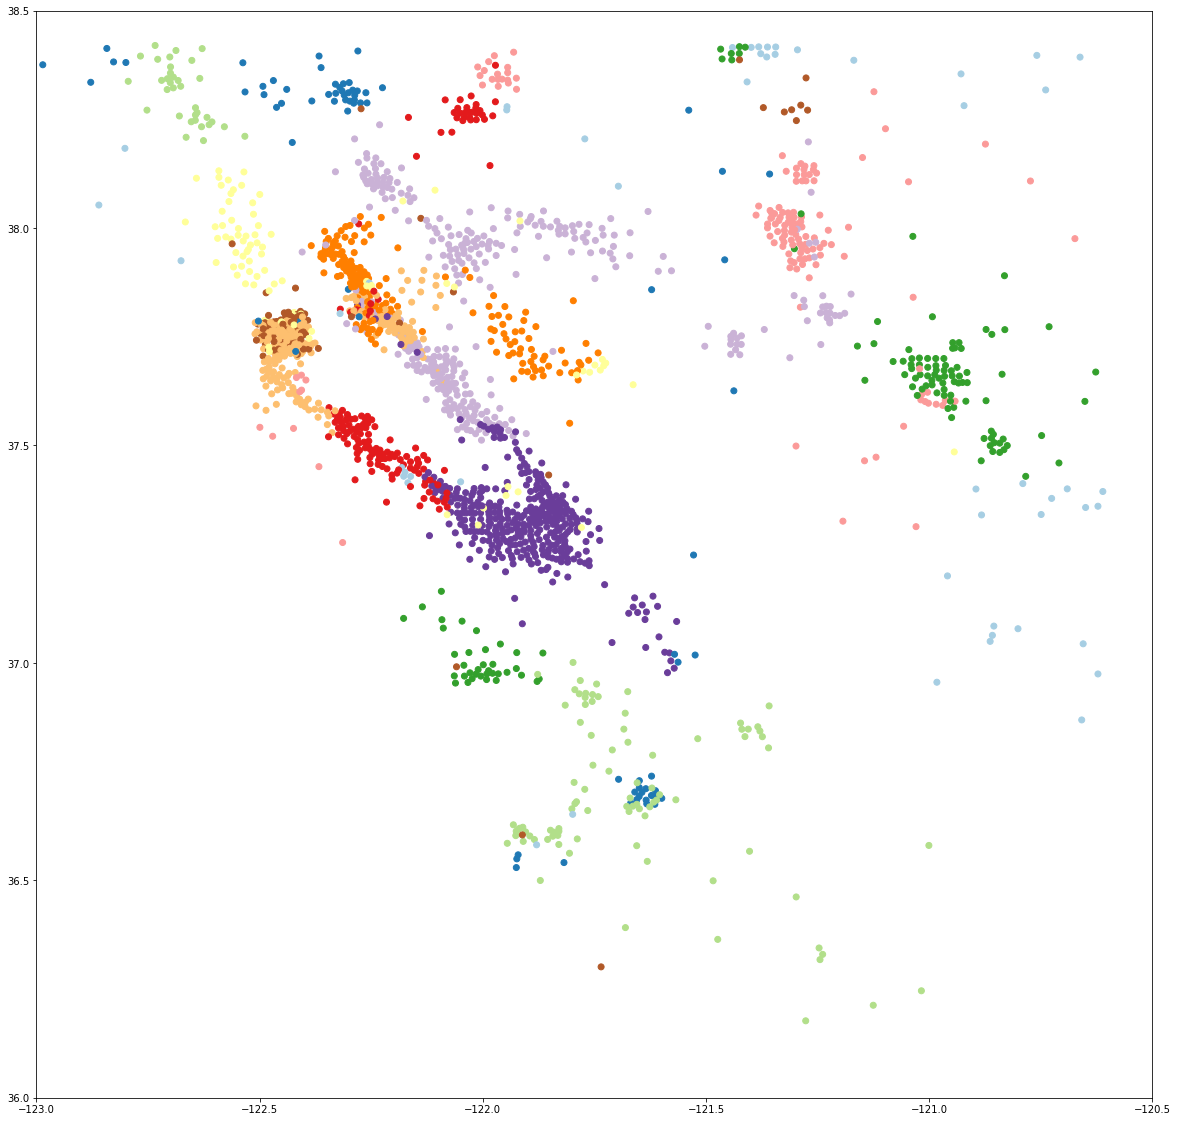

In [198]:
plt.figure(figsize=(20,20))
flow_max = df_merged_bay['FLOW'].max()
plt.scatter(df_results['INTPTLONG'],df_results['INTPTLAT'], c=df_results['cluster_id'].values, cmap='Paired')

plt.ylim(36,38.5)
plt.xlim(-123,-120.5) 

In [168]:
with open('apikey.txt') as f:
    api_key = f.readline()
    f.close

In [169]:
# Use google maps api
gmaps.configure(api_key=api_key) # Fill in with your API key

#Set up your map
fig = gmaps.figure()
colors = list(df_results['color'].values)
locations = list(zip(df_results['INTPTLAT'],df_results['INTPTLONG']))
symbols = gmaps.symbol_layer(
        locations,
        fill_color=colors,
        stroke_color=colors,
        scale=2)
fig.add_layer(symbols)
fig

Figure(layout=FigureLayout(height='420px'))